In [1]:
import re

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

from downstream import bed_metrics as bm

Calculate intersection metrics manually or using all loci pipeline:

```
#! python /mnt/stripe/washu/downstream/reports/loci_intersection_report.py -o /mnt/stripe/bio/experiments/aging/loci_of_interest/tuned8_plots -p 24 --skip-stats --tool span
```

In [2]:
root = Path("/mnt/stripe/bio/experiments/aging/loci_of_interest/tuned8_plots")

Auto-generated plots are not good enough for slides, so let's generated better plots using calculated intersection metric matricies. Also let's leave only "*_both.bed" differential chipseq peaks, because "*_young.bed" and "*_old.bed" are just subsets of both.

In [3]:
def color_annotator_hist(label):
    m = re.match(".*[^_]*(H[0-9][a-z0-9]+)_.*", label, re.IGNORECASE)
    hist = "else" if not m else m.group(1)
    color = {'H3K4me1':'blue', 'H3K4me3':'orange', 'H3K27ac':'black',
             'H3K27me3':'green', 'H3K36me3':'lightgray', 'else': 'magenta'}[hist]

    return (("Histone", color),)

def extract_tool(label):
    l = label.lower()
    tools = ["diff_bind", "span", "diffreps", "macs", "sicer"]
    for t in tools:
        if t in l:
            return t

    return "else"

def color_annotator_tool(label):
    colors = {
        "else": "black",
        "diff_bind": "brown",
        "span": "magenta",
        "diffreps": "skyblue",
        "macs": "gray"
    }
    
    return (("Diff ChipSeq Tool", colors[extract_tool(label)]),)

def sort_by_hist_mod(l):
    m = re.match(".*_(H[A-Za-z0-9]+)_.*", l)
    return (m and m.group(1), l)        

# Diff ChipSeq vs Weak Consensus

In [4]:
df = pd.DataFrame.from_csv(root / "chipseq_diff_loci@weak_consensus_common.csv")

filtered_rows = sorted([l for l in df.index if l.endswith("_both.bed")], key=sort_by_hist_mod)
df = df.loc[filtered_rows, :]

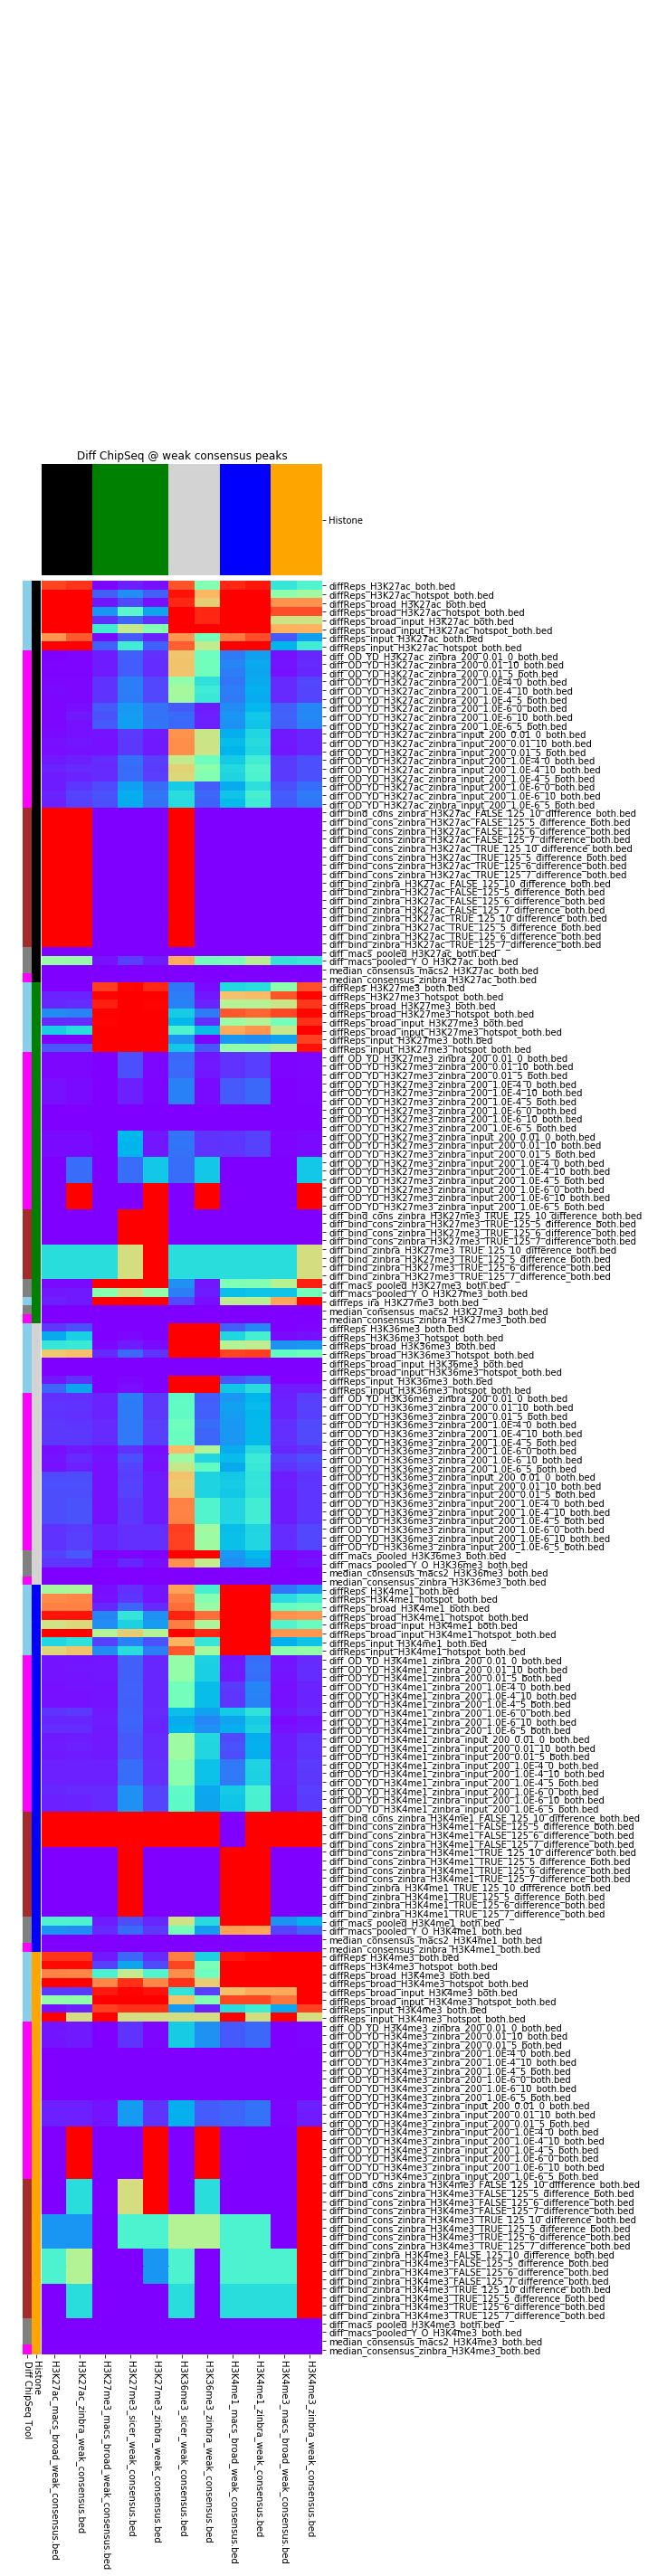

In [5]:
bm.plot_metric_heatmap("Diff ChipSeq @ weak consensus peaks", df, figsize=(8, 60), cbar=False,
                       row_color_annotator=bm.color_annotator_chain(color_annotator_tool,
                                                                    color_annotator_hist),
                       col_color_annotator=color_annotator_hist)

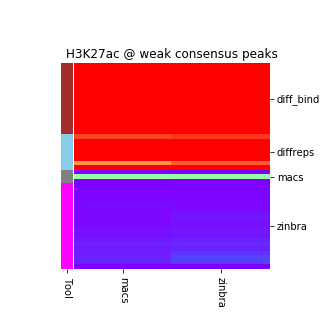

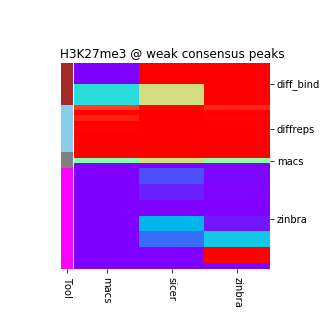

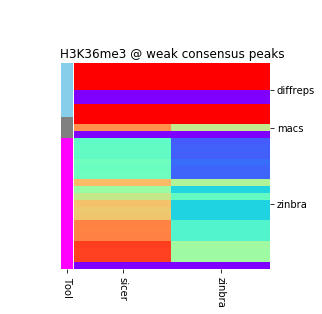

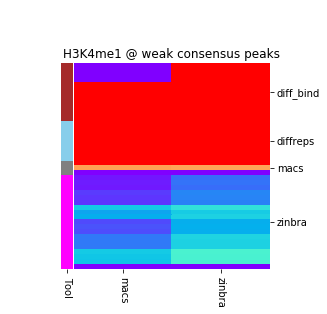

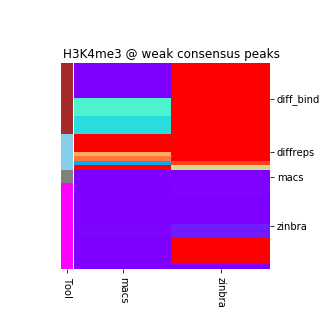

In [6]:
hide_tools_options = True

################################################

from collections import Counter
from collections import OrderedDict

hists = sorted({h for h,l in (sort_by_hist_mod(l) for l in df.index) if h})
for h in hists:
    fcols = [l for l in df.columns if h in l]
    frows = [l for l in df.index if h in l]
    frows.sort(key = lambda l: extract_tool(l))
    
    
    fdf = df.loc[frows, fcols]
    g = bm.plot_metric_heatmap("{} @ weak consensus peaks".format(h), fdf, 
                               figsize=(6, 6) if hide_tools_options else (8, 20),
                               row_color_annotator=color_annotator_tool, 
                               cbar=False, show_or_save_plot=False)
    
    if hide_tools_options:

        # Tools names as OY
        tools_cnt = Counter()
        tools = OrderedDict()
        for l in frows:
            tool = extract_tool(l)
            tools[tool] = None
            tools_cnt[tool] += 1
        tools_counts = [tools_cnt[t] for t in tools]
    
        ticks = [sum(tools_counts[0:k]) + tools_counts[k]/2 for k in range(len(tools_counts))]
        g.ax_heatmap.set_yticks(ticks)
        g.ax_heatmap.set_yticklabels(tools.keys(), rotation=0, verticalalignment = 'center')
        # Turn off annotations
        #g.ax_row_colors.set_xticks([])
        g.ax_row_colors.set_xticklabels(["Tool"])

        # Fix Names OX:
        g.ax_heatmap.set_xticklabels([extract_tool(c) for c in fcols])
        

    plt.show()

# Diff ChipSeq vs Diff ChipSeq

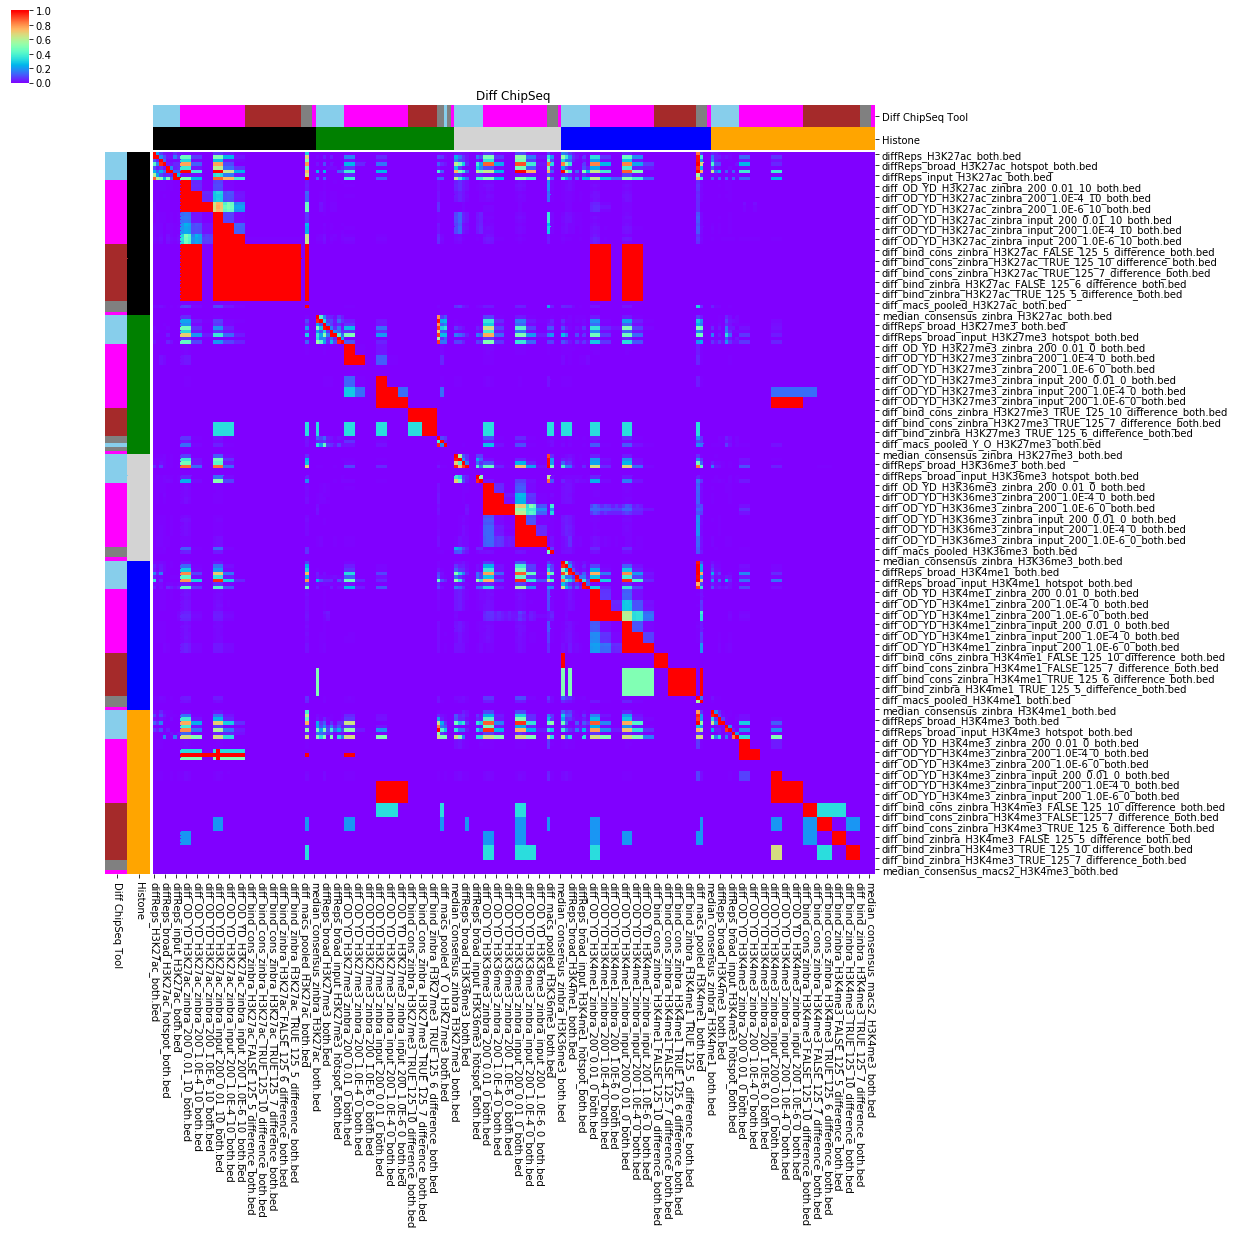

In [7]:
df = pd.DataFrame.from_csv(root / "chipseq_diff_loci@chipseq_diff_loci.csv")

def sort_by_hist_mod(l):
    m = re.match(".*_(H[A-Za-z0-9]+)_.*", l)
    return (m and m.group(1), l)

frows = sorted([l for l in df.index if l.endswith("_both.bed")], key=sort_by_hist_mod)
fcols = sorted([l for l in df.columns if l.endswith("_both.bed")], key=sort_by_hist_mod)
df = df.loc[frows, fcols]

bm.plot_metric_heatmap("Diff ChipSeq", df, figsize=(20, 20),
                       row_color_annotator=bm.color_annotator_chain(color_annotator_tool,
                                                                    color_annotator_hist),
                       col_color_annotator=bm.color_annotator_chain(color_annotator_tool,
                                                                    color_annotator_hist))

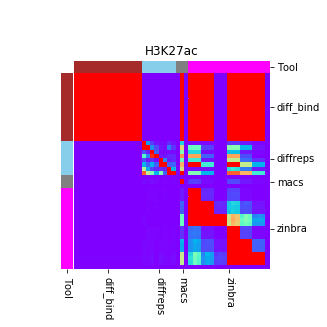

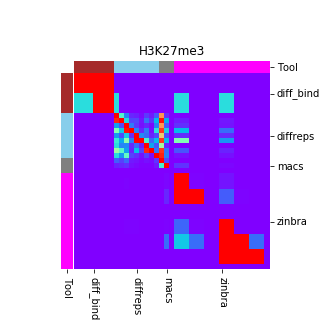

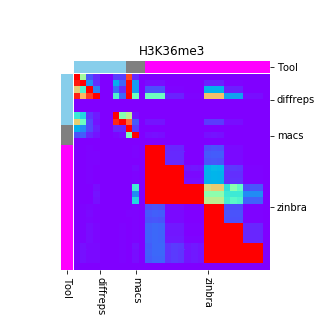

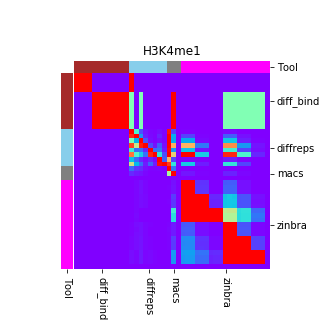

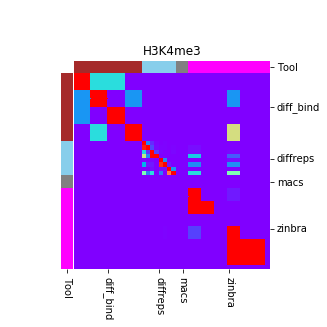

In [8]:
hide_tools_options = True

hists = sorted({h for h,l in (sort_by_hist_mod(l) for l in df.index) if h})
for h in hists:
    sorter = lambda l: extract_tool(l)
    assert df.columns.tolist() == df.index.tolist()
    
    labels = sorted([l for l in df.columns if h in l], key = sorter)
    fdf = df.loc[labels, labels]
    g = bm.plot_metric_heatmap(h, fdf, 
                               figsize=(6, 6) if hide_tools_options else (20, 20),
                               cbar=False, show_or_save_plot=False,
                               row_color_annotator=color_annotator_tool,
                               col_color_annotator=color_annotator_tool)
    
    if hide_tools_options:

        # Tools names as OY
        tools_cnt = Counter()
        tools = OrderedDict()
        for l in labels:
            tool = extract_tool(l)
            tools[tool] = None
            tools_cnt[tool] += 1
        tools_counts = [tools_cnt[t] for t in tools]
    
        ticks = [sum(tools_counts[0:k]) + tools_counts[k]/2 for k in range(len(tools_counts))]
        g.ax_heatmap.set_xticks(ticks)
        g.ax_heatmap.set_xticklabels(tools.keys(), rotation=-90, horizontalalignment = 'center')

        g.ax_heatmap.set_yticks(ticks)
        g.ax_heatmap.set_yticklabels(tools.keys(), rotation=0, verticalalignment = 'center')
        
        # Turn off annotations
        g.ax_row_colors.set_xticklabels(["Tool"])
        g.ax_col_colors.set_yticklabels(["Tool"])

        # Fix Names OX:
        #g.ax_heatmap.set_xticklabels([extract_tool(c) for c in fcols])
    plt.show()